In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans, Birch

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier

import advanced_processor_chain_factory
from data import preprocess_data, load_dataset
from evaluation import analysis, cluster_analysis

In [2]:
def last_layer_activations(model, X):
    acs = [X] + (model.n_layers_ - 1) * [None]
    return model._forward_pass(acs)[model.n_layers_ - 2]

In [3]:
dataset = load_dataset()
DEBUG = False

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *preprocess_data(dataset, processor_chain=advanced_processor_chain_factory.create('lem'), debug=DEBUG))

Pandas Apply:   0%|          | 0/45000 [00:00<?, ?it/s]

In [38]:
vectorizer = CountVectorizer(max_features=2000)

In [39]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [40]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 500, 250, 5), activation='tanh', warm_start=True)
mlp.fit(X_train_vec, Y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(1000, 500, 250, 5),
              warm_start=True)

In [41]:
analysis(Y_test, mlp.predict(X_test_vec))

Report: Classification
               precision    recall  f1-score   support

    positive       0.86      0.84      0.85      5632
    negative       0.84      0.86      0.85      5618

    accuracy                           0.85     11250
   macro avg       0.85      0.85      0.85     11250
weighted avg       0.85      0.85      0.85     11250

Matrix: Confusion
 [[4734  898]
 [ 789 4829]]
Accuracy:
 0.8500444444444445


0.8513001322168356

In [42]:
X_train_vec = last_layer_activations(mlp, X_train_vec)
X_test_vec = last_layer_activations(mlp, X_test_vec)

# Show Clusters

In [43]:
tsne = PCA(n_components=2)
X_tsne = tsne.fit_transform(X_train_vec)

In [44]:
def plot_clustering(Y, X_tsne):
    u_labels = np.unique(Y)
    for i in u_labels:
        points = X_tsne[Y == i]
        plt.scatter(points[:, 0], points[:, 1], label=i)
    plt.show()

# Plot Actual Data

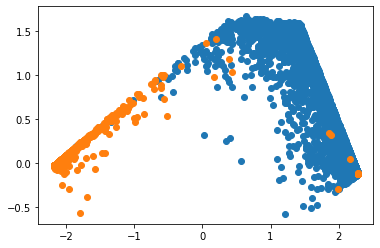

In [45]:
plot_clustering(Y_train, X_tsne)

In [46]:
def plot_cv_results(results, x_name):

    plt.xlabel(x_name)
    plt.ylabel("Score")
    ax = plt.gca()
    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_%s' % x_name].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='dotted', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

In [47]:
scoring = {'adjusted_rand_score':  make_scorer(metrics.adjusted_rand_score), 'adjusted_mutual_info_score':  make_scorer(metrics.adjusted_mutual_info_score)}
cols2show = ['mean_test_adjusted_rand_score',
             'rank_test_adjusted_rand_score',
             'mean_train_adjusted_rand_score',
             'mean_test_adjusted_mutual_info_score',
             'rank_test_adjusted_mutual_info_score',
             'mean_train_adjusted_mutual_info_score']

# Birch

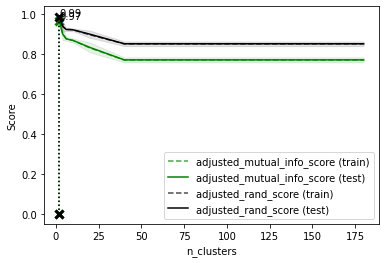

In [48]:
birtch = Birch()
n_clusters = list(range(2, 11, 2)) + [20 * i for i in range(1,10)]

birtch = GridSearchCV(birtch, {'n_clusters': n_clusters}, scoring=scoring,  refit='adjusted_rand_score', return_train_score=True, cv=3, n_jobs=-1)
birtch.fit(X_train_vec, Y_train)
plot_cv_results(birtch.cv_results_, 'n_clusters')
results = pd.DataFrame(birtch.cv_results_)[cols2show + ['param_n_clusters']]

In [49]:
cluster_analysis(Y_test, birtch.predict(X_test_vec))

Test Evaluation:
adjusted_rand_score: 0.4823923119161879
adjusted_mutual_info_score: 0.3839591344440935


In [50]:
results[results['rank_test_adjusted_rand_score'] == 1].head()

,mean_test_adjusted_rand_score,rank_test_adjusted_rand_score,mean_train_adjusted_rand_score,mean_test_adjusted_mutual_info_score,rank_test_adjusted_mutual_info_score,mean_train_adjusted_mutual_info_score,param_n_clusters
0,0.987005,1,0.987771,0.968523,1,0.970117,2


In [51]:
results[results['rank_test_adjusted_mutual_info_score'] == 1].head()

,mean_test_adjusted_rand_score,rank_test_adjusted_rand_score,mean_train_adjusted_rand_score,mean_test_adjusted_mutual_info_score,rank_test_adjusted_mutual_info_score,mean_train_adjusted_mutual_info_score,param_n_clusters
0,0.987005,1,0.987771,0.968523,1,0.970117,2


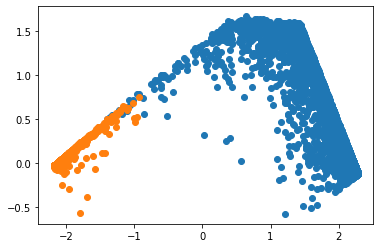

In [52]:
plot_clustering(birtch.predict(X_train_vec), X_tsne)

# KMeans

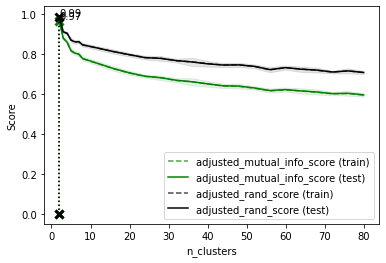

In [53]:
n_clusters = list(range(2, 10)) + [4 * i for i in range(4,21)]
kmeans = KMeans()
scoring = {'adjusted_rand_score':  make_scorer(metrics.adjusted_rand_score), 'adjusted_mutual_info_score':  make_scorer(metrics.adjusted_mutual_info_score)}
kmeans = GridSearchCV(kmeans, {'n_clusters': n_clusters}, scoring=scoring,  refit='adjusted_rand_score', return_train_score=True, n_jobs=-1)
kmeans.fit(X_train_vec, Y_train)
plot_cv_results(kmeans.cv_results_, 'n_clusters')
results = pd.DataFrame(kmeans.cv_results_)[cols2show + ['param_n_clusters']]

In [54]:
cluster_analysis(Y_test, kmeans.predict(X_test_vec))

Test Evaluation:
adjusted_rand_score: 0.4935705853546286
adjusted_mutual_info_score: 0.3948286503743867


In [55]:
results[results['rank_test_adjusted_rand_score'] == 1]

,mean_test_adjusted_rand_score,rank_test_adjusted_rand_score,mean_train_adjusted_rand_score,mean_test_adjusted_mutual_info_score,rank_test_adjusted_mutual_info_score,mean_train_adjusted_mutual_info_score,param_n_clusters
0,0.986771,1,0.986887,0.968547,1,0.968517,2


In [56]:
results[results['rank_test_adjusted_mutual_info_score'] == 1]

,mean_test_adjusted_rand_score,rank_test_adjusted_rand_score,mean_train_adjusted_rand_score,mean_test_adjusted_mutual_info_score,rank_test_adjusted_mutual_info_score,mean_train_adjusted_mutual_info_score,param_n_clusters
0,0.986771,1,0.986887,0.968547,1,0.968517,2


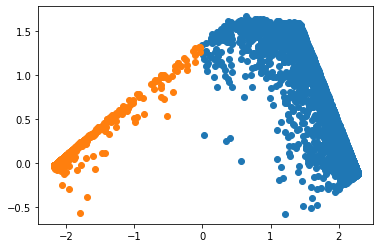

In [57]:
plot_clustering(kmeans.predict(X_train_vec), X_tsne)

# GMM

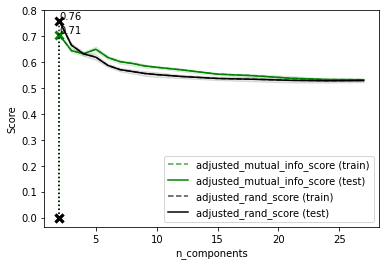

In [58]:
gmm = GaussianMixture()
scoring = {'adjusted_rand_score':  make_scorer(metrics.adjusted_rand_score), 'adjusted_mutual_info_score':  make_scorer(metrics.adjusted_mutual_info_score)}
gmm = GridSearchCV(gmm, {'n_components': list(range(2,11)) + [3*i for i in range(4, 10)]}, scoring=scoring,  refit='adjusted_rand_score', return_train_score=True, n_jobs=-1)
gmm.fit(X_train_vec, Y_train)
plot_cv_results(gmm.cv_results_, 'n_components')
results = pd.DataFrame(gmm.cv_results_)[cols2show + ['param_n_components']]

In [59]:
cluster_analysis(Y_test, gmm.predict(X_test_vec))

Test Evaluation:
adjusted_rand_score: 0.3726443665975857
adjusted_mutual_info_score: 0.32709846403870824


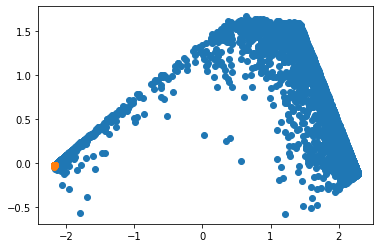

In [60]:
plot_clustering(gmm.predict(X_train_vec), X_tsne)

In [61]:
results[results['rank_test_adjusted_rand_score'] == 1]

,mean_test_adjusted_rand_score,rank_test_adjusted_rand_score,mean_train_adjusted_rand_score,mean_test_adjusted_mutual_info_score,rank_test_adjusted_mutual_info_score,mean_train_adjusted_mutual_info_score,param_n_components
0,0.759218,1,0.759317,0.706084,1,0.70616,2


In [62]:
results[results['rank_test_adjusted_mutual_info_score'] == 1]


,mean_test_adjusted_rand_score,rank_test_adjusted_rand_score,mean_train_adjusted_rand_score,mean_test_adjusted_mutual_info_score,rank_test_adjusted_mutual_info_score,mean_train_adjusted_mutual_info_score,param_n_components
0,0.759218,1,0.759317,0.706084,1,0.70616,2


# Cluster Member's Similarity in Action

In [63]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_vec)
Y_train_pred = kmeans.predict(X_train_vec)

Cluster 0:
0	movie fatal flaw someone could walk open back door highly secure medical facility unbelievable person walk around facility enter dr office bad write bad edit predictable movie not sure film got make except film canada probably receive government grant must say person play aaron cory monteith good jobunless really bore nothing else watch television would say kill time otherwise movie actor would want resume
1	movie plain bad simply awful string bad movie bollywood end must run excuse make awful movie not problem seem mainly director movie good actor prove past ability deliver great performancebut direct poorly poor script not help eitherthis movie plenty ridiculous moment bad edit first half instance st big concert ajay devgan meet om puri run away year ago talk om puri find say beware friendship salman load crap seriously not mention baaad soundtrack whatever happen shankar ehsaan loyajay devgun total miscast portray rockstaronly save grace good performance second half aja

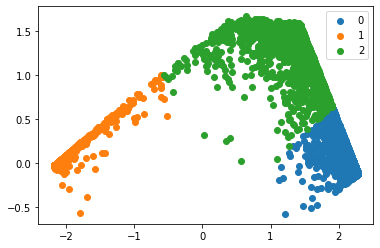

In [64]:
for i in range(3):
    print(f'Cluster {i}:')
    points = X_tsne[Y_train_pred == i]
    plt.scatter(points[:, 0], points[:, 1], label=i)
    for i,item in enumerate(X_train[Y_train_pred == i].head(5)):
        print(f'{i}\t{item}')
plt.legend()
plt.show()

# Fine Tuning

In [65]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id = '1uykBJxWH5v5BsSuuwM0r9WLiKWQrDiDJ', dest_path=('./dataset2.csv'))
dataset2 = pd.read_csv('./dataset2.csv')

In [66]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    *preprocess_data(dataset2, processor_chain=advanced_processor_chain_factory.create('lem'), debug=False))

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [67]:
X_train_vec2 = vectorizer.transform(X_train2)
X_test_vec2 = vectorizer.transform(X_test2)

In [68]:
del X_train2, X_test2

In [69]:
model = MLPClassifier(hidden_layer_sizes=(1000, 500, 250, 5), activation='tanh')
model.fit(X_train_vec2, Y_train2)
analysis(Y_test2, model.predict(X_test_vec2))

Report: Classification
               precision    recall  f1-score   support

    positive       0.70      0.75      0.72        56
    negative       0.78      0.74      0.76        69

    accuracy                           0.74       125
   macro avg       0.74      0.74      0.74       125
weighted avg       0.75      0.74      0.74       125

Matrix: Confusion
 [[42 14]
 [18 51]]
Accuracy:
 0.744


0.7611940298507462

In [70]:
mlp.partial_fit(X_train_vec2, Y_train2)
analysis(Y_test2, mlp.predict(X_test_vec2))

Report: Classification
               precision    recall  f1-score   support

    positive       0.75      0.82      0.79        56
    negative       0.84      0.78      0.81        69

    accuracy                           0.80       125
   macro avg       0.80      0.80      0.80       125
weighted avg       0.80      0.80      0.80       125

Matrix: Confusion
 [[46 10]
 [15 54]]
Accuracy:
 0.8


0.81203007518797